In [1]:
import credentials as cr
import SQL_requests as rq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from spotify_api import Spotify_api
from db_connect import Db_connect
from recommendation_system import Recommendation


%load_ext autoreload
%autoreload 2

## Application parameters

In [2]:
# redirect_uri = 'http://localhost/'
data_path = cr.DATA_PATH

sp = Spotify_api()
db = Db_connect()
rc = Recommendation()

warnings.filterwarnings("ignore")

## Get datas using Spotify API  
I get my personnal spotify datas using spotify api and spotify_api.py class. The Pandas dataframes created are converted into csv files which will be used to create the sqlite database.

In [6]:
playlists_df = sp.get_playlists_with_tracks()

features_df = sp.get_playlist_features(playlists_df)
features_df.drop_duplicates(inplace=True)

tracks_df = sp.get_tracks(features_df)

contains_df = sp.get_contains(playlists_df)

playlists_df.to_csv(data_path + 'playlists.csv', encoding='utf-8')
features_df.to_csv(data_path + 'features.csv', encoding='utf-8')
tracks_df.to_csv(data_path + 'tracks.csv', encoding='utf-8')
contains_df.to_csv(data_path + 'contains.csv', encoding='utf-8', index=False)

## DataBase connect and creation

Create the SQLite database, create or update the tables with spotify datas (playlist, feature, track).

In [8]:
db.init_connection()
db.create_tables([rq.CREATE_PLAYLIST, rq.CREATE_TRACK, rq.CREATE_TRACK_FEATURES, rq.CREATE_CONTAINS])
db.insert_data(rq.INSERT_PLAYLISTS, data_path + 'playlists.csv')
db.insert_data(rq.INSERT_TRACKS_FEATURES, data_path + 'features.csv')
db.insert_data(rq.INSERT_TRACKS, data_path + 'tracks.csv')
db.insert_data(rq.INSERT_CONTAINS, data_path + 'contains.csv')
db.close_connection()

## Developping the algorithm

I start by getting the 'Top 30' (6AsIwsN6mH7dQSChLsqSlY) playlist from the database, which will be used to developp and test the algorithm.  
Let's get the first try and view the results.

In [6]:
db.init_connection()
top_30_titles = pd.read_sql_query(rq.SELECT_PLAYLIST_TITLES + "'6AsIwsN6mH7dQSChLsqSlY'", db.connector).set_index('id')
track_titles = pd.read_sql_query(rq.SELECT_TRACKS_TITLES, db.connector).set_index('id')
track_features = pd.read_sql_query(rq.SELECT_TRACKS_FEATURES, db.connector).set_index('id')
db.close_connection()

### Vizualisation of the targetted playlist :

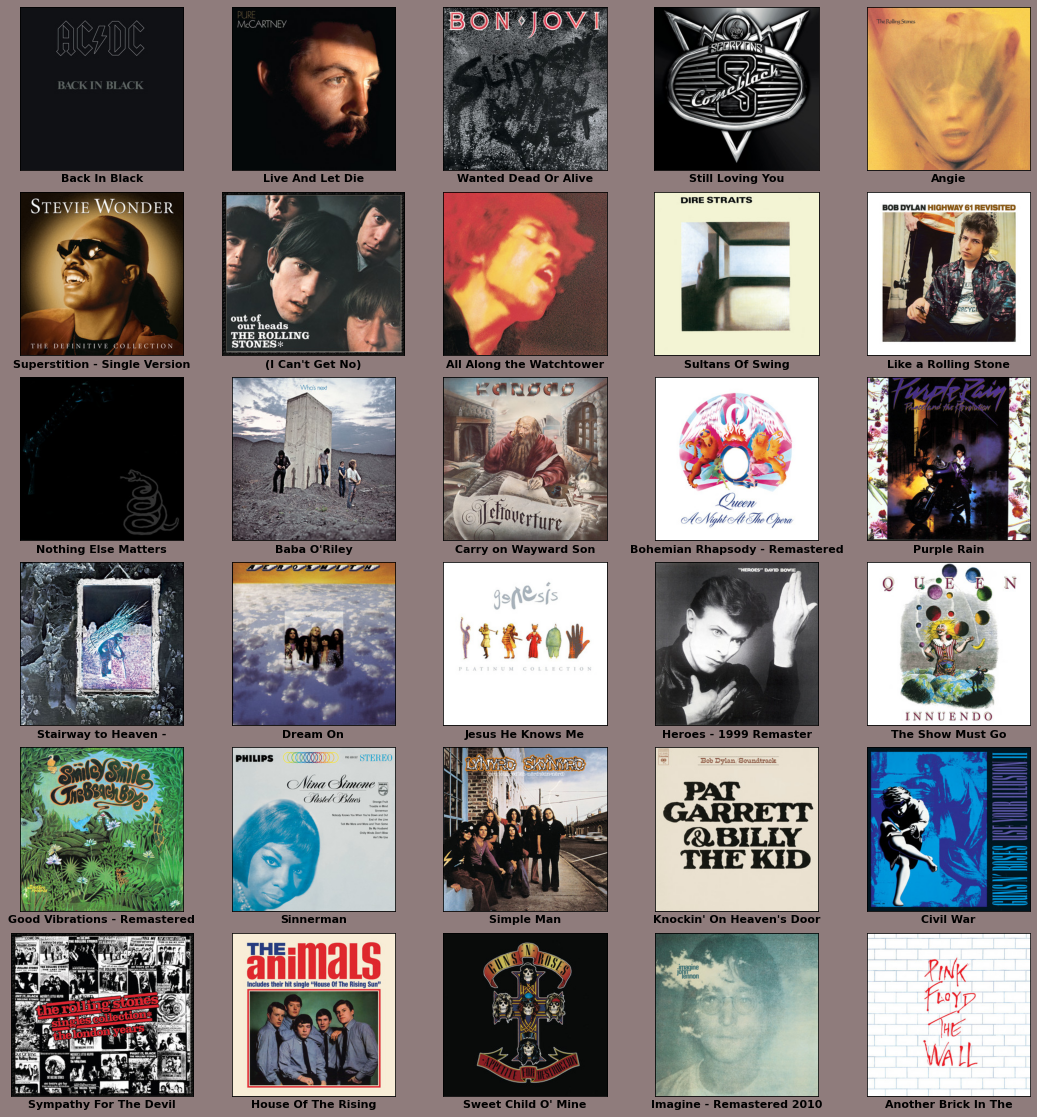

In [5]:
rc.visualize_cover(top_30_titles)

## Getting a recommandation

### Top 30 playlist

Accuracy: 0.8


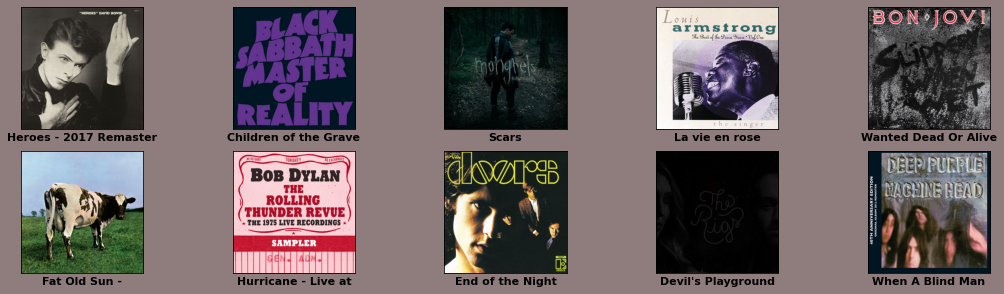

,name,proba
id,,
7Jh1bpe76CNTCgdgAdBw4Z,Heroes - 2017 Remaster,0.822630
3ZuVfQriS93y6ofwbIf7lp,Children of the Grave,0.811430
6ctGf5r6PEsUvN0msqOV9W,Scars,0.805088
1UH4viviUjZnS9aWgPGrk0,La vie en rose - Single Version,0.729384
2fY6tqgrlrg1ky9fgs0t5u,Wanted Dead Or Alive,0.728611
7BgCcmvjRx5fDyJXn2GbxU,Fat Old Sun - 2011 Remastered Version,0.708555
3tydlYMRrQPki1X97cfvJ5,"Hurricane - Live at Boston Music Hall, Boston,...",0.706855
09ezgACZuwWZt6CtQSSLRG,End of the Night,0.693926
3WdHywW5eesvHX9pj5z8eT,Devil's Playground,0.691610


In [5]:
rc.knnRecommandation("'6AsIwsN6mH7dQSChLsqSlY'")

### Playlist Metal

Accuracy: 0.7333333333333333


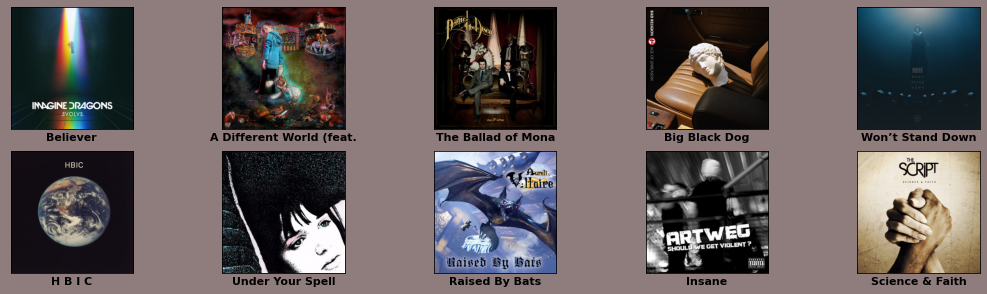

,name,proba
id,,
0pqnGHJpmpxLKifKRmU6WP,Believer,0.809182
3ns1Hn52RB28zGVHiFvz7W,A Different World (feat. Corey Taylor),0.806306
5rLi8B8qgk6qThwRnKHW2P,The Ballad of Mona Lisa,0.801576
5uujHxR0Wt919ZnbrZO2bS,Big Black Dog,0.798061
6hIr2IDeBDXfRFk0rYe5Tz,Won’t Stand Down,0.784471
3VTlWV4YoSgVvyfJI0IMZR,H B I C,0.774472
2cSRuejq6DU9U6OkSmUw17,Under Your Spell,0.703275
4bEcLMMdxvKsC51IhbFZm0,Raised By Bats,0.692694
0tPTQd3G9c4RvmyY7BHTyL,Insane,0.656821


In [18]:
rc.knnRecommandation('5CcqhGeE9BdmT2hc6iXj7Z')

Accuracy: 0.7037037037037037
Parameters found :  {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'brute'}


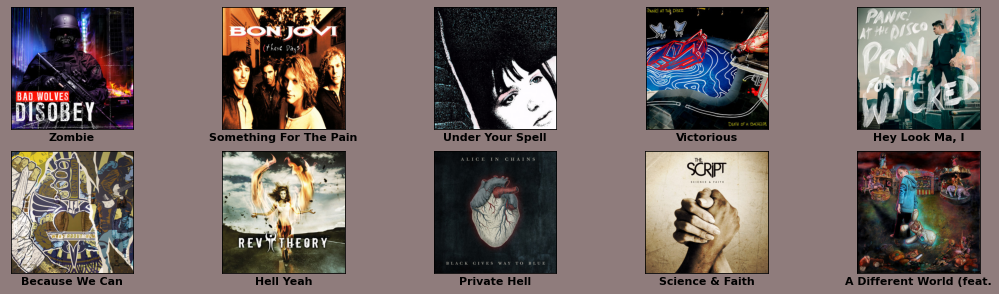

,name,proba
id,,
1eadPrzB2P0ikQcqhKSAtv,Zombie,0.626729
3CacmA1yAXx6K2XJjlR3nm,Something For The Pain,0.591788
2cSRuejq6DU9U6OkSmUw17,Under Your Spell,0.584944
6od5hFv9IT5JHc7NEF9HRv,Victorious,0.583991
22oEJW6r2rMb9z4IntfyEa,"Hey Look Ma, I Made It",0.569965
2ICDzsIPWJZk0YR0tPFDlQ,Because We Can,0.567712
2qABxQZhfAthNxszLiSsUw,Hell Yeah,0.562941
5dndBL5i7RAr4CNVjxeX0V,Private Hell,0.560887
0cnouzAiEjdjXB5xVVQ8Vo,Science & Faith,0.556242


In [45]:
rc.knnRecommandation_best_params('5CcqhGeE9BdmT2hc6iXj7Z')

### Favoris playlist with RandomizedSearchCV

Accuracy: 0.675
Parameters found :  {'weights': 'distance', 'n_neighbors': 9, 'metric': 'minkowski', 'algorithm': 'brute'}


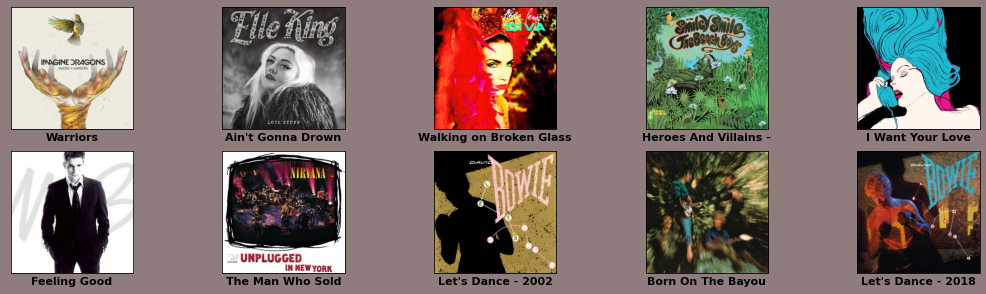

,name,proba
id,,
1sWeSMifj6Z6kZyI6z3bRc,Warriors,0.945905
2bKazIbV8uwFTyMdUS0vct,Ain't Gonna Drown,0.782826
4CcSw8wQAHYf4XNckayPoc,Walking on Broken Glass,0.764394
7BO7ZbaEmgCSSp3znPMxN4,Heroes And Villains - Remastered 2001,0.676210
6CJzsJdJgYQc6NbsKngXGz,I Want Your Love,0.673248
3I09LQbHS3NSU46Ly3tPpR,Feeling Good,0.668774
15VRO9CQwMpbqUYA7e6Hwg,The Man Who Sold The World,0.656147
4cVHMHgmWgudD399ZdhQ3L,Let's Dance - 2002 Remaster,0.652585
587bVBCHYW5Q2VNRLig4AS,Born On The Bayou,0.644431


In [55]:
rc.knnRecommandation_best_params('7g3LG2ege5DXSFoBFGT3Yr')

Accuracy: 0.675
Parameters found :  {'weights': 'distance', 'n_neighbors': 8, 'metric': 'cosine', 'algorithm': 'brute'}


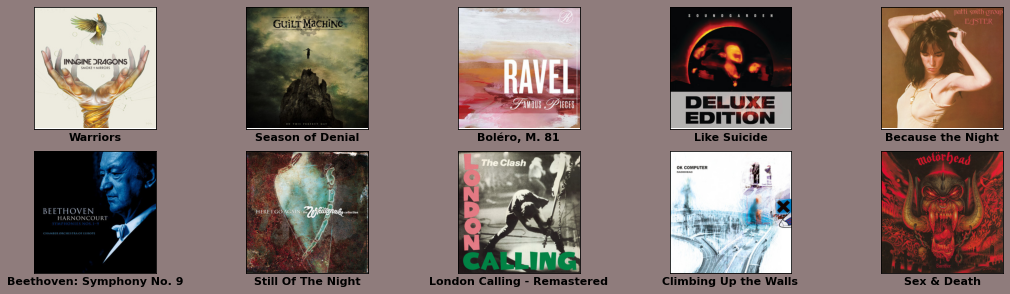

,name,proba
id,,
1sWeSMifj6Z6kZyI6z3bRc,Warriors,0.999617
7KrtKsJvFtme82L1us9m38,Season of Denial,0.794667
0CDNVJ4YiK3XSi9JzUfZRD,"Boléro, M. 81",0.728242
0KhYJOx8HLA1ANTSaxU2KH,Like Suicide,0.715570
0lIoY4ZQsdn5QzhraM9o9u,Because the Night,0.713224
6lnttZF0hDaVyVZBEgpJ3I,"Beethoven: Symphony No. 9 in D Minor, Op. 125 ...",0.712006
4TDpf3g3PUl7fzHXuL2UUY,Still Of The Night,0.679333
5jzma6gCzYtKB1DbEwFZKH,London Calling - Remastered,0.671734
0R332cdlS9LyE0Ge2PSlVC,Climbing Up the Walls,0.669514


In [58]:
rc.knnRecommandation_best_params('7g3LG2ege5DXSFoBFGT3Yr')